In [1]:
import CGAT.IOTools as IOTools
import glob
import collections
import math
import pandas as pd
import numpy as np
from datetime import datetime

%load_ext rpy2.ipython




In [2]:
%%R
library(Hmisc)
library(ggplot2)
library(reshape2)
library(plyr)

my_theme <- theme_bw() + theme(aspect.ratio=1, text=element_text(size=20))

/home/FILESERVER5/proteomics/tss38/devel/py36-v1/conda-install/envs/py36-v1/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/devel/py36-v1/conda-install/envs/py36-v1/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: survival

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/devel/py36-v1/conda-install/envs/py36-v1/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Formula

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/devel/py36-v1/conda-install/envs/py36-v1/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/devel/py36-v1/conda-install/envs/py36-v1/lib/python3.6/site-pack

In [3]:
full_infiles = glob.glob(
    "../../trizol_paper/dosage/manuscript_pipeline/coverage.dir/single_contig_windows.dir/sig_shift_genes_windows_*_intersections_full_desc.tsv")
print(len(full_infiles))

24


In [4]:
infiles = glob.glob(
    "../../trizol_paper/dosage/manuscript_pipeline/coverage.dir/single_contig_windows.dir/sig_shift_genes_windows_*_intersections.tsv")

In [5]:
proteins = set()
window_counts = {}
window_counts_full = {}
for infile in full_infiles:
    with IOTools.openFile(infile) as inf:
        for line in inf:
            contig, start, stop, window, desc = line.strip().split("\t")[0:5]
            protein, cell_line, rep = desc.split("_")
            proteins.add(protein)
            #print(line, contig, start, stop, window, desc, protein, cell_line, rep)
            
            gene, n = window.split("_")
            
            if gene not in window_counts_full:
                window_counts_full[gene] = {}
            
            if n not in window_counts_full[gene]:
                window_counts_full[gene][n] = {}
            
            if protein not in window_counts_full[gene][n]:
                window_counts_full[gene][n][protein] = set()
                
            window_counts_full[gene][n][protein].add(rep)
        
    #raise ValueError()

print(len(window_counts_full))
print(len(proteins))


8860
119


In [6]:
print(window_counts_full['ENSG00000161980'])

{'37': {'SUB1': {'2'}, 'NOLC1': {'2'}}, '38': {'SUB1': {'2'}, 'LIN28B': {'2', '1'}, 'NOLC1': {'2'}}, '39': {'SUB1': {'2'}, 'LIN28B': {'2', '1'}, 'NOLC1': {'2'}}, '40': {'SUB1': {'2'}, 'LIN28B': {'2', '1'}, 'NOLC1': {'2'}}, '41': {'SUB1': {'2'}, 'LIN28B': {'2', '1'}, 'NOLC1': {'2'}}, '42': {'SUB1': {'2', '1'}, 'LIN28B': {'2', '1'}, 'NOLC1': {'2'}}, '43': {'SUB1': {'2', '1'}, 'LIN28B': {'2', '1'}, 'NOLC1': {'2'}}, '44': {'SUB1': {'2', '1'}, 'LIN28B': {'2', '1'}, 'NOLC1': {'2'}}, '45': {'SUB1': {'2', '1'}, 'LIN28B': {'2', '1'}, 'NOLC1': {'2'}}, '46': {'SUB1': {'2', '1'}, 'LIN28B': {'2', '1'}, 'NOLC1': {'2'}}, '47': {'SUB1': {'2', '1'}, 'NOLC1': {'2'}}, '48': {'NOLC1': {'2'}}, '49': {'NOLC1': {'2'}}, '90': {'ILF3': {'2', '1'}}, '91': {'ILF3': {'2', '1'}}, '92': {'ILF3': {'2', '1'}}, '93': {'ILF3': {'2', '1'}}, '94': {'ILF3': {'2', '1'}}, '95': {'ILF3': {'2', '1'}}, '96': {'ILF3': {'2', '1'}}, '97': {'ILF3': {'2', '1'}}, '234': {'KHSRP': {'2'}}, '235': {'KHSRP': {'2'}}, '236': {'KHSRP': {'2

In [7]:
#counts = collections.Counter()
#for gene in window_counts_full:
#    for n in window_counts_full[gene]:
#        counts[window_counts[gene][n]] += 1
#        
#print(counts.most_common())

In [8]:
windows_sig = pd.read_table(
    "../../trizol_paper/dosage/notebooks/deseq2_results.tsv",
    sep="\t", 
    usecols=["Row.names", "contig", "start", "end", "baseMean", "log2FoldChange", "padj"])


eCLIP_counts_either = []
eCLIP_counts_both = []
for window in windows_sig['Row.names']:
    gene, n = window.split("_")
    if gene in window_counts_full and n in window_counts_full[gene]:
        n_both_rep = 0
        for protein in window_counts_full[gene][n]:
            if window_counts_full[gene][n][protein] == set(("1","2")):
                n_both_rep+=1
        eCLIP_counts_both.append(n_both_rep)
        eCLIP_counts_either.append(len(window_counts_full[gene][n]))
    else:
        eCLIP_counts_either.append(0)
        eCLIP_counts_both.append(0)

windows_sig['eCLIP_peaks_either'] = list(map(int, eCLIP_counts_either))
windows_sig['eCLIP_peaks_both'] = list(map(int, eCLIP_counts_both))
windows_sig['sig'] = list(map(int, windows_sig.apply(
    axis=1, func=lambda x: x['padj']<0.01 and x['log2FoldChange'] < 0)))

    
#print(windows_sig.head(30))
print(windows_sig.head())

print(windows_sig['eCLIP_peaks_either'].value_counts())
print(windows_sig['eCLIP_peaks_both'].value_counts())


                  Row.names    baseMean  log2FoldChange           padj contig  \
328951  ENSG00000133112_381  704.526417        2.377479  2.287427e-153  chr13   
328952  ENSG00000133112_382  487.708529        2.579851  1.853189e-149  chr13   
79058     ENSG00000075624_7  559.967855       -4.035280  1.643532e-139   chr7   
79069     ENSG00000075624_8  436.604204       -3.772876  5.220394e-129   chr7   
185521  ENSG00000108107_146  958.840591        2.219051  4.844314e-120  chr19   

           start       end  eCLIP_peaks_either  eCLIP_peaks_both  sig  
328951  45341090  45341130                   2                 1    0  
328952  45341110  45341150                   3                 1    0  
79058    5527290   5527330                   3                 1    1  
79069    5527310   5527350                   3                 2    1  
185521  55388264  55388304                   1                 0    0  
0     460539
1     129939
2      72111
3      42727
4      25163
5      14529
6  

In [9]:
time_start = datetime.now()
for protein_n, protein in enumerate(proteins, 1):
    protein_col = np.zeros(len(windows_sig['Row.names']))
    for ix, window in enumerate(windows_sig['Row.names']):
        gene, n = window.split("_")
        if gene in window_counts_full and n in window_counts_full[gene]:
            if protein in window_counts_full[gene][n]:
                if window_counts_full[gene][n][protein] == set(("1","2")):
                    protein_col[ix]=1
    windows_sig[protein] = protein_col
    print("processed %s proteins: %s. Predicted finish: %s\r" % (
        protein_n, protein,
        (time_start + (datetime.now()-time_start)*(len(proteins)/protein_n)).strftime('%Y-%m-%d %H:%M:%S')), end="")

print("processed all proteins %s - %s" % (
    time_start.strftime('%Y-%m-%d %H:%M:%S'), datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

processed all proteins 2018-01-23 13:57:32 - 2018-01-23 13:59:129:1212


In [10]:
print(windows_sig.shape)
print(windows_sig.head())
protein_counts = windows_sig[list(proteins)].apply(axis=0, func=sum)

(762440, 129)
                  Row.names    baseMean  log2FoldChange           padj contig  \
328951  ENSG00000133112_381  704.526417        2.377479  2.287427e-153  chr13   
328952  ENSG00000133112_382  487.708529        2.579851  1.853189e-149  chr13   
79058     ENSG00000075624_7  559.967855       -4.035280  1.643532e-139   chr7   
79069     ENSG00000075624_8  436.604204       -3.772876  5.220394e-129   chr7   
185521  ENSG00000108107_146  958.840591        2.219051  4.844314e-120  chr19   

           start       end  eCLIP_peaks_either  eCLIP_peaks_both  sig  ...    \
328951  45341090  45341130                   2                 1    0  ...     
328952  45341110  45341150                   3                 1    0  ...     
79058    5527290   5527330                   3                 1    1  ...     
79069    5527310   5527350                   3                 2    1  ...     
185521  55388264  55388304                   1                 0    0  ...     

        SLTM  SUPV

In [11]:
protein_counts = protein_counts.sort_values(ascending=False)
print(sum(protein_counts>1000))
print(protein_counts)

57
GRWD1       28200.0
DDX24       23524.0
YBX3        22091.0
PRPF8       21798.0
UPF1        20813.0
UCHL5       20711.0
PPIG        20465.0
RPS3        17802.0
IGF2BP1     17138.0
PCBP2       17108.0
ZNF622      16209.0
FXR2        14354.0
IGF2BP2     13137.0
SF3B4       12950.0
DDX3X       12557.0
EIF3H       10457.0
SND1        10438.0
FMR1        10066.0
PUM2         8527.0
EFTUD2       6962.0
SUB1         6916.0
METAP2       6694.0
LIN28B       6208.0
FAM120A      6150.0
BUD13        5809.0
DDX55        5686.0
GEMIN5       5185.0
IGF2BP3      4169.0
RBM15        4158.0
SF3A3        3957.0
             ...   
SLBP          190.0
DGCR8         182.0
FTO           180.0
NPM1          171.0
HNRNPC        168.0
FKBP4         164.0
EXOSC5        161.0
NCBP2         158.0
AARS          152.0
SFPQ          134.0
DHX30         104.0
SRSF7         101.0
RBM5           96.0
TROVE2         84.0
XRCC6          71.0
RPS11          54.0
LARP7          52.0
DDX42          39.0
GNL3           30

In [12]:
print(windows_sig['sig'].value_counts())

0    698698
1     63742
Name: sig, dtype: int64


In [13]:
def fixedBinSize(input_array, n=10):
    assert n<=len(input_array), "n must be <= length of input_array"
    step = len(input_array)/n
    
    last_start = 0
    last_end = 0
    
    order = [i[0] for i in sorted(enumerate(input_array), key=lambda x:x[1])]
    
    sorted_array = sorted(input_array)
    
    bin_array = np.zeros(len(input_array))
    bin_n = 0
    
    while last_end < len(input_array):
        last_end = last_start + step
        #print(last_start, last_end, step)
        bin_array[math.ceil(last_start):math.ceil(last_end)] = bin_n
        bin_n += 1
        last_start = last_end
        #print(bin_array)
    
    return([x[1] for x in sorted(enumerate(bin_array), key=lambda x:order[x[0]])])
    
test_array = [1,2,3,1,2,4,10]
#fixedBinSize(test_array, 6)


windows_sig['binned_mean'] = fixedBinSize(windows_sig['baseMean'].tolist(), 20)
windows_sig['binned_peak_n'] = np.digitize(windows_sig['eCLIP_peaks_both'], bins=[0,1,2,3,4,5,6,7,500])-1

print(windows_sig.head())

                  Row.names    baseMean  log2FoldChange           padj contig  \
328951  ENSG00000133112_381  704.526417        2.377479  2.287427e-153  chr13   
328952  ENSG00000133112_382  487.708529        2.579851  1.853189e-149  chr13   
79058     ENSG00000075624_7  559.967855       -4.035280  1.643532e-139   chr7   
79069     ENSG00000075624_8  436.604204       -3.772876  5.220394e-129   chr7   
185521  ENSG00000108107_146  958.840591        2.219051  4.844314e-120  chr19   

           start       end  eCLIP_peaks_either  eCLIP_peaks_both  sig  \
328951  45341090  45341130                   2                 1    0   
328952  45341110  45341150                   3                 1    0   
79058    5527290   5527330                   3                 1    1   
79069    5527310   5527350                   3                 2    1   
185521  55388264  55388304                   1                 0    0   

            ...        DHX30  FAM120A  PPIG  SRSF1  HLTF  SRSF9  RBM5  DDX

In [14]:
print(windows_sig['binned_peak_n'].value_counts())
print(windows_sig[windows_sig['binned_peak_n']==0].head())
print(windows_sig[windows_sig['binned_peak_n']==7].head())

0    525072
1    126056
2     57578
3     28278
4     13807
5      6384
6      2798
7      2467
Name: binned_peak_n, dtype: int64
                  Row.names    baseMean  log2FoldChange           padj contig  \
185521  ENSG00000108107_146  958.840591        2.219051  4.844314e-120  chr19   
644002  ENSG00000183569_575  542.322130        2.362754   8.299979e-88  chr22   
277615    ENSG00000124610_2  443.786482        2.138121   1.378199e-81   chr6   
54227     ENSG00000065978_6  444.346233        1.812939   1.633077e-79   chr1   
703241   ENSG00000198886_47  625.856959        1.734995   1.234844e-66   chrM   

           start       end  eCLIP_peaks_either  eCLIP_peaks_both  sig  \
185521  55388264  55388304                   1                 0    0   
644002  42565116  42565156                   0                 0    0   
277615  26017124  26017164                   0                 0    0   
54227   42682546  42682586                   0                 0    0   
703241     11699  

In [15]:
print(windows_sig['binned_mean'].value_counts())

7.0     38122
6.0     38122
2.0     38122
0.0     38122
9.0     38122
10.0    38122
11.0    38122
12.0    38122
3.0     38122
13.0    38122
14.0    38122
15.0    38122
1.0     38122
16.0    38122
17.0    38122
18.0    38122
4.0     38122
19.0    38122
5.0     38122
8.0     38122
Name: binned_mean, dtype: int64


In [16]:
sig_counter = collections.Counter()

binned_mean_counts = windows_sig['binned_mean'].value_counts()

for bin_n, count in binned_mean_counts.iteritems():
    
    tmp_mean_df = windows_sig[windows_sig['binned_mean']==bin_n]
    sig_counts = tmp_mean_df['sig'].value_counts()
    if 1 in sig_counts:
        prob = sig_counts[1]/(sig_counts[1] + sig_counts[0])
    else:
        prob = 0
    
    sig_counter[bin_n] = prob
    
for x,y in sig_counter.items():
    print(x,y)

7.0 0
6.0 0
2.0 0
0.0 0
9.0 0.0811080216148
10.0 0.104086878968
11.0 0.08693143067
12.0 0.0871675148208
3.0 0
13.0 0.119301190913
14.0 0.0917055768323
15.0 0.132495671791
1.0 0
16.0 0.186270395047
17.0 0.223597922459
18.0 0.261450081318
4.0 0
19.0 0.297938198416
5.0 0
8.0 0


In [17]:
rows = []

for peak_count in set(windows_sig['binned_peak_n']):
    tmp_df = windows_sig[windows_sig['binned_peak_n']==peak_count]
    binned_mean_counts = tmp_df['binned_mean'].value_counts()
    #print(peak_count)
    #print(binned_mean_counts)
    sum_prob = 0
    for n in range(1,100):
        for bin_n, count in binned_mean_counts.iteritems():
            sig_prob = sig_counter[bin_n]
            rc = np.random.choice([0,1], size=count, p=[1-sig_prob, sig_prob])
            #print(sum(rc), count, sum(rc)/count)
            sum_prob += sum(rc)


        sum_prob /= len(tmp_df)
        #print(sum_prob)

        sig_counts = tmp_df['sig'].value_counts()
        if 1 in sig_counts:
            prob = sig_counts[1]/(sig_counts[1] + sig_counts[0])
        else:
            prob = 0

        rows.append((peak_count, sum_prob, prob, n))

obs_vs_random = pd.DataFrame.from_records(rows, columns=["eCLIP_bin", "random", "obs", "iteration"])

print(obs_vs_random)

     eCLIP_bin    random       obs  iteration
0            0  0.070011  0.064033          1
1            0  0.069840  0.064033          2
2            0  0.069888  0.064033          3
3            0  0.070267  0.064033          4
4            0  0.069711  0.064033          5
5            0  0.069234  0.064033          6
6            0  0.070076  0.064033          7
7            0  0.070191  0.064033          8
8            0  0.069905  0.064033          9
9            0  0.070192  0.064033         10
10           0  0.069926  0.064033         11
11           0  0.069855  0.064033         12
12           0  0.070556  0.064033         13
13           0  0.069737  0.064033         14
14           0  0.069389  0.064033         15
15           0  0.070109  0.064033         16
16           0  0.069648  0.064033         17
17           0  0.069535  0.064033         18
18           0  0.069825  0.064033         19
19           0  0.070105  0.064033         20
20           0  0.069598  0.064033

/home/FILESERVER5/proteomics/tss38/devel/py36-v1/conda-install/envs/py36-v1/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


  eCLIP_bin     random        obs iteration
0         0 0.07001135 0.06403312         1
1         0 0.06984008 0.06403312         2
2         0 0.06988769 0.06403312         3
3         0 0.07026669 0.06403312         4
4         0 0.06971057 0.06403312         5
5         0 0.06923445 0.06403312         6


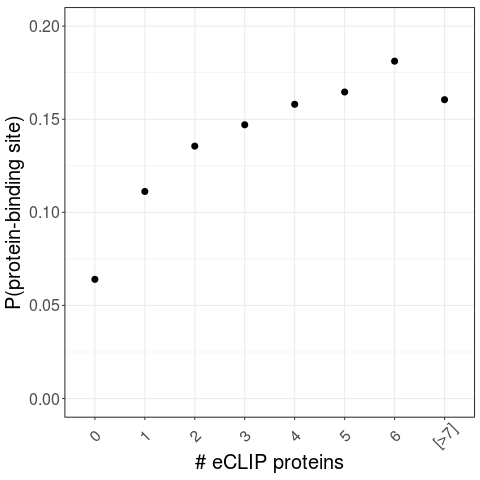

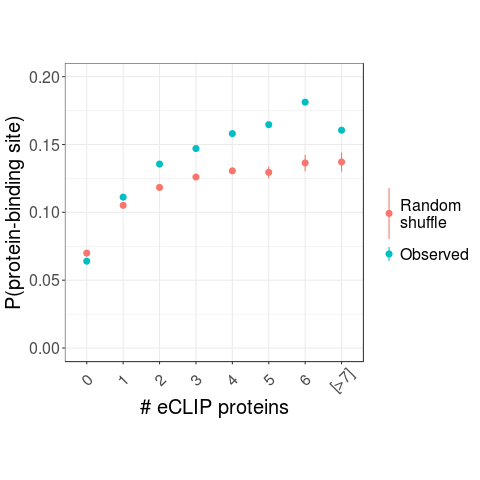

In [18]:
%%R -i obs_vs_random

print(head(obs_vs_random))

obs_vs_random[['eCLIP_bin']] <- mapvalues(
    obs_vs_random[['eCLIP_bin']] , from=7, to=c("[>7]"))

#[obs_vs_random[['eCLIP_bin']]==7] <- "[7-9]"
#obs_vs_random[['eCLIP_bin']][obs_vs_random[['eCLIP_bin']]==8] <- "[9-12]"
#obs_vs_random[['eCLIP_bin']][obs_vs_random[['eCLIP_bin']]==9] <- ">[12-15]"
#obs_vs_random[['eCLIP_bin']][obs_vs_random[['eCLIP_bin']]==10] <- ">15"

obs_vs_random[['eCLIP_bin']] <- factor(obs_vs_random[['eCLIP_bin']], levels=unique(obs_vs_random[['eCLIP_bin']]))

df_for_plotting <- melt(obs_vs_random, id.vars=c("eCLIP_bin", "iteration"))

p <- ggplot(df_for_plotting[df_for_plotting$variable == "obs",], aes(eCLIP_bin, value)) +
stat_summary(fun.data = mean_sdl, fun.args = list(mult = 1)) +
theme_bw() +
theme(aspect.ratio=1, text=element_text(size=20)) +
theme(axis.text.x=element_text(angle=45, vjust=0.5, hjust=0.5)) +
xlab("# eCLIP proteins") + ylab("P(protein-binding site)") +
ylim(0,0.2)

print(p)

p2 <- p %+% df_for_plotting + aes(colour=variable) +
scale_colour_discrete(name="", labels=c("\nRandom\nshuffle\n", "Observed"))

print(p2)
ggsave("./eCLIP_n_peaks_prob_oops.png")

Repeat the above but shuffling the OOPS putative protein binding sites

In [19]:
eCLIP_counter = collections.Counter()

binned_mean_counts = windows_sig['binned_mean'].value_counts()
binned_mean_counts = windows_sig[windows_sig['sig']==0]['binned_mean'].value_counts()

for bin_n, count in binned_mean_counts.iteritems():
    
    tmp_mean_df = windows_sig[windows_sig['sig']==0]
    tmp_mean_df = tmp_mean_df[tmp_mean_df['binned_mean']==bin_n]
    eCLIP_counts = tmp_mean_df['binned_peak_n'].value_counts()
    eCLIP_counter[bin_n] = {x:y for x, y in eCLIP_counts.iteritems()}    

for x,y in eCLIP_counter.items():
    print(x,y)
    

    
for bin_n, count in binned_mean_counts.iteritems():
    
    tmp_mean_df = windows_sig[windows_sig['sig']==1]
    tmp_mean_df = tmp_mean_df[tmp_mean_df['binned_mean']==bin_n]
    eCLIP_counts = tmp_mean_df['binned_peak_n'].value_counts()
    eCLIP_counter[bin_n] = {x:y for x, y in eCLIP_counts.iteritems()}    

for x,y in eCLIP_counter.items():
    print(x,y)
    

7.0 {0: 28301, 1: 5592, 2: 2263, 3: 1044, 4: 523, 5: 210, 6: 103, 7: 86}
1.0 {0: 31283, 1: 4123, 2: 1485, 3: 642, 4: 321, 5: 149, 6: 69, 7: 50}
2.0 {0: 30697, 1: 4383, 2: 1599, 3: 740, 4: 369, 5: 198, 6: 69, 7: 67}
0.0 {0: 31552, 1: 3939, 2: 1468, 3: 633, 4: 294, 5: 127, 6: 57, 7: 52}
3.0 {0: 30226, 1: 4491, 2: 1824, 3: 821, 4: 403, 5: 197, 7: 85, 6: 75}
6.0 {0: 28786, 1: 5367, 2: 2135, 3: 1002, 4: 446, 5: 208, 6: 98, 7: 80}
8.0 {0: 27817, 1: 5810, 2: 2444, 3: 1092, 4: 516, 5: 246, 6: 103, 7: 94}
4.0 {0: 29821, 1: 4837, 2: 1909, 3: 851, 4: 384, 5: 182, 7: 71, 6: 67}
5.0 {0: 29236, 1: 5062, 2: 2079, 3: 922, 4: 459, 5: 204, 6: 92, 7: 68}
9.0 {0: 25147, 1: 5409, 2: 2380, 3: 1159, 4: 500, 5: 256, 7: 95, 6: 84}
11.0 {0: 23648, 1: 6071, 2: 2709, 3: 1292, 4: 623, 5: 254, 7: 106, 6: 105}
12.0 {0: 23160, 1: 6367, 2: 2725, 3: 1393, 4: 649, 5: 300, 6: 112, 7: 93}
14.0 {0: 21988, 1: 6647, 2: 3132, 3: 1469, 4: 758, 5: 345, 7: 151, 6: 136}
10.0 {0: 23939, 1: 5573, 2: 2396, 3: 1217, 4: 557, 5: 257, 6

In [20]:
observed = windows_sig[windows_sig['sig']==1]['binned_peak_n'].value_counts()
observed = observed.reset_index()
observed.columns = ["eCLIP_peaks", "count"]
observed['fraction'] = observed['count'] / sum(observed['count'])

rows = []

tmp_df = windows_sig[windows_sig['sig']==1]
mean_bin_counts = tmp_df['binned_mean'].value_counts()

for n in range(1,100):
    for bin_n, count in mean_bin_counts.iteritems():
        probs = eCLIP_counter[bin_n]

        try:
            rc = np.random.choice(list(probs.keys()), size=count, p=list([x/sum(probs.values()) for x in probs.values()]))
        except:
            print(bin_n, prob)
            raise ValueError()

        rc_counts = collections.Counter(rc)

        for peak_bin, bin_count in rc_counts.most_common():
            rows.append((peak_bin, bin_count, bin_count/count, n))
                
        
random = pd.DataFrame.from_records(rows, columns=list(observed.columns) + ["iteration"])

observed['type'] = "observed"
random['type'] = "random"

obs_vs_random = pd.concat([observed, random])
obs_vs_random_agg = pd.DataFrame(obs_vs_random.groupby(
    ["type", "eCLIP_peaks"])['fraction'].aggregate([np.mean, np.std]))
obs_vs_random_agg.reset_index(inplace=True)

obs_vs_random_agg2 = pd.DataFrame(obs_vs_random.groupby(
    ["type", "eCLIP_peaks"])['count'].aggregate(np.sum))
obs_vs_random_agg2['fraction'] = obs_vs_random_agg2.groupby("type")['count'].apply(lambda x: x/sum(x))
obs_vs_random_agg2.reset_index(inplace=True)

print(obs_vs_random_agg)
print(obs_vs_random_agg2)

        type  eCLIP_peaks      mean       std
0   observed            0  0.527470       NaN
1   observed            1  0.219949       NaN
2   observed            2  0.122462       NaN
3   observed            3  0.065232       NaN
4   observed            4  0.034232       NaN
5   observed            5  0.016488       NaN
6   observed            6  0.007954       NaN
7   observed            7  0.006213       NaN
8     random            0  0.578572  0.110935
9     random            1  0.208619  0.028110
10    random            2  0.106922  0.034297
11    random            3  0.054652  0.023728
12    random            4  0.027307  0.015404
13    random            5  0.013017  0.007436
14    random            6  0.006049  0.004222
15    random            7  0.004872  0.003026
        type  eCLIP_peaks    count  fraction
0   observed            0    33622  0.527470
1   observed            1    14020  0.219949
2   observed            2     7806  0.122462
3   observed            3     4158  0.

In [21]:
#obs_vs_random_agg = obs_vs_random_agg.sort_values(["type", "eCLIP_peaks"], ascending=[True, False])
obs_vs_random_agg['cumsum'] = obs_vs_random_agg.groupby("type")['mean'].apply(np.cumsum)
obs_vs_random_agg['eCLIP_peaks_min'] = max(obs_vs_random_agg['eCLIP_peaks']) - obs_vs_random_agg['eCLIP_peaks']


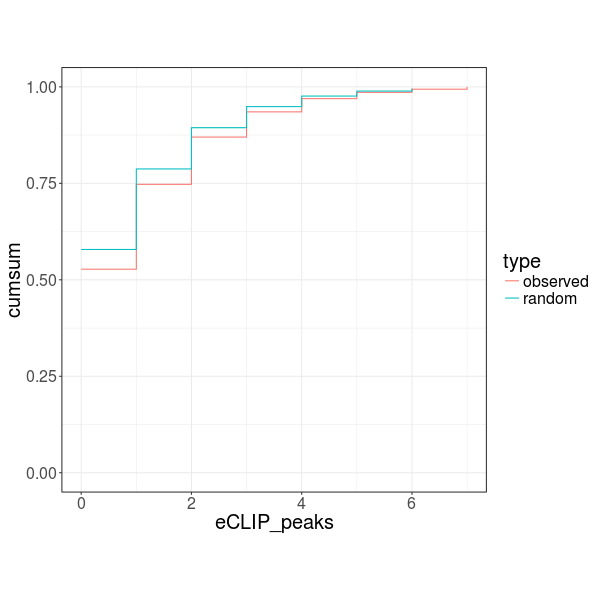

In [22]:
%%R -i obs_vs_random_agg -w 600 -h 600

p = ggplot(obs_vs_random_agg, aes(eCLIP_peaks, cumsum, colour=type)) +
geom_step() +
ylim(0,1) +
my_theme

print(p)

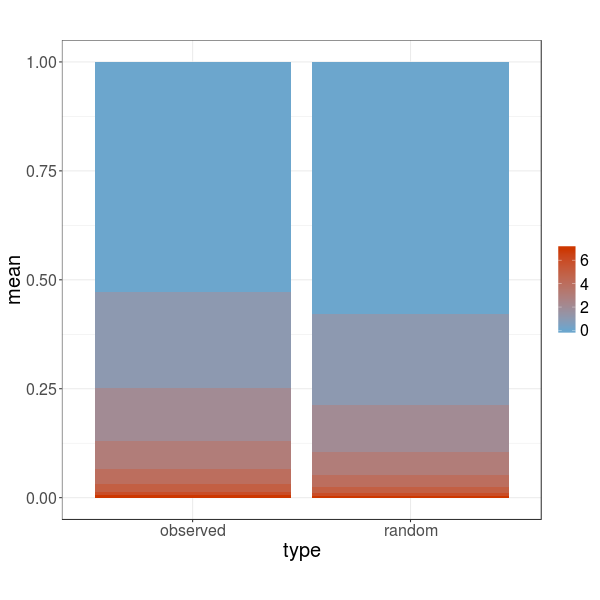

In [23]:
%%R -i obs_vs_random_agg -w 600 -h 600

                             
p <- ggplot(obs_vs_random_agg[order(-obs_vs_random_agg['eCLIP_peaks']),],
            aes(type, mean, fill=eCLIP_peaks)) +
geom_bar(stat="identity", position="fill") +
scale_fill_gradient(low="skyblue3", high="orangered3", name="") +
my_theme
print(p)



/home/FILESERVER5/proteomics/tss38/devel/py36-v1/conda-install/envs/py36-v1/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following `from` values were not present in `x`: 8, 9, 10, 11

  warnings.warn(x, RRuntimeWarning)


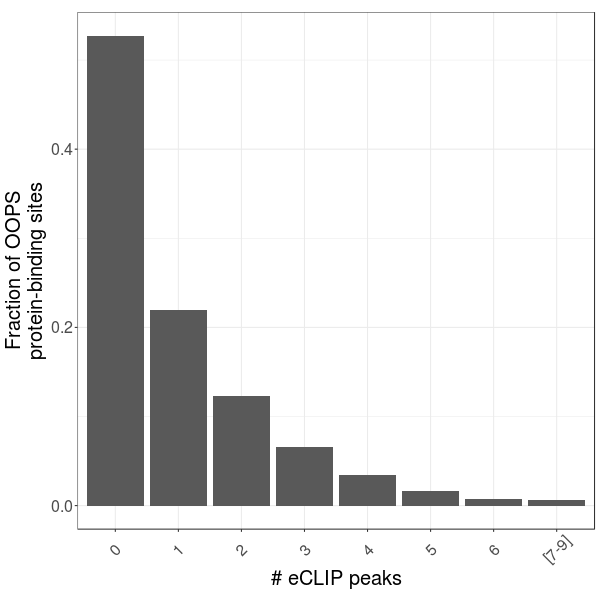

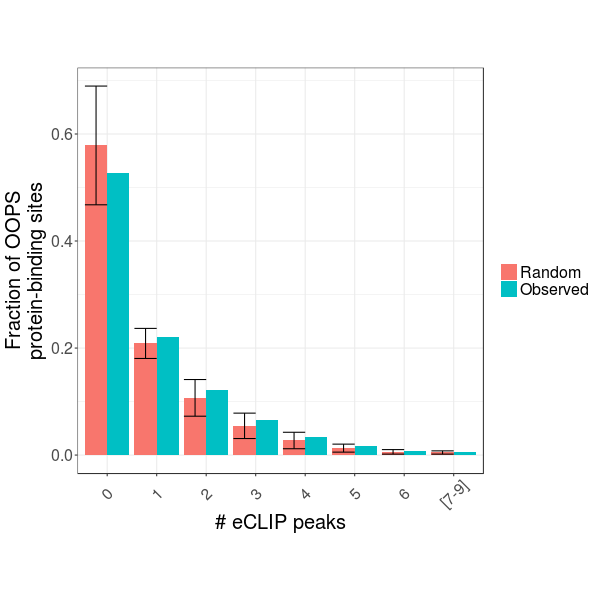

In [24]:
%%R -i obs_vs_random_agg -w 600 -h 600

#obs_vs_random_agg[['eCLIP_peaks']] <- factor(
#    obs_vs_random_agg[['eCLIP_peaks']], levels=rev(unique(obs_vs_random_agg[['eCLIP_peaks']])))

obs_vs_random_agg[['eCLIP_peaks']] <- mapvalues(
    obs_vs_random_agg[['eCLIP_peaks']] , from=7:11, to=c("[7-9]","[9-12]","[12-15]","[15-20]",">20"))

obs_vs_random_agg[['eCLIP_peaks']] <- factor(obs_vs_random_agg[['eCLIP_peaks']],
                                           levels=unique(obs_vs_random_agg[['eCLIP_peaks']]))




p <- ggplot(obs_vs_random_agg[obs_vs_random_agg$type=="observed",], colour="black",
            aes(eCLIP_peaks, mean)) +
geom_bar(stat="identity", position="dodge") +
scale_fill_discrete(name="", labels=c("Random", "Observed")) +
xlab("# eCLIP peaks") + ylab("Fraction of OOPS\nprotein-binding sites") +
my_theme +
theme(axis.text.x=element_text(angle=45, vjust=0.5))

print(p)

print(p %+% obs_vs_random_agg + aes(fill=factor(type, levels=c("random", "observed"))) + 
      geom_errorbar(aes(ymax=(mean+std), ymin=(mean-std)), position=position_dodge()))

In [25]:
%%R -i windows_sig
print(head(windows_sig))

                 Row.names baseMean log2FoldChange          padj contig
328951 ENSG00000133112_381 704.5264       2.377479 2.287427e-153  chr13
328952 ENSG00000133112_382 487.7085       2.579851 1.853189e-149  chr13
79058    ENSG00000075624_7 559.9679      -4.035280 1.643532e-139   chr7
79069    ENSG00000075624_8 436.6042      -3.772876 5.220394e-129   chr7
185521 ENSG00000108107_146 958.8406       2.219051 4.844314e-120  chr19
644003 ENSG00000183569_576 316.4985       2.774384 7.336813e-120  chr22
          start      end eCLIP_peaks_either eCLIP_peaks_both sig GRSF1 IGF2BP1
328951 45341090 45341130                  2                1   0     0       0
328952 45341110 45341150                  3                1   0     0       0
79058   5527290  5527330                  3                1   1     0       0
79069   5527310  5527350                  3                2   1     0       0
185521 55388264 55388304                  1                0   0     0       0
644003 42565136 425651

In [26]:
%%R
window_model = glm(windows_sig, formula=sig ~ log(baseMean, 2)*eCLIP_peaks_either, family="binomial")
print(summary(window_model))

window_model = glm(windows_sig, formula=sig ~ log(baseMean, 2)*log(eCLIP_peaks_either+1,2), family="binomial")
print(summary(window_model))

window_model = glm(windows_sig, formula=sig ~ log(baseMean, 2)*eCLIP_peaks_both, family="binomial")
print(summary(window_model))

window_model = glm(windows_sig, formula=sig ~ log(baseMean, 2)*log(eCLIP_peaks_both+1,2), family="binomial")
print(summary(window_model))


Call:
glm(formula = sig ~ log(baseMean, 2) * eCLIP_peaks_either, family = "binomial", 
    data = windows_sig)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6431  -0.4057  -0.2828  -0.2183   2.5506  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -3.933210   0.009983 -393.99   <2e-16 ***
log(baseMean, 2)                     0.680875   0.003369  202.11   <2e-16 ***
eCLIP_peaks_either                   0.152324   0.004386   34.73   <2e-16 ***
log(baseMean, 2):eCLIP_peaks_either -0.031975   0.001287  -24.84   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 438374  on 762439  degrees of freedom
Residual deviance: 372824  on 762436  degrees of freedom
AIC: 372832

Number of Fisher Scoring iterations: 6


Call:
glm(formula = sig ~ log(baseMean, 2) * log(eCLIP_peaks_either + 
    

In [27]:
%%R
window_model = glm(windows_sig, formula=sig ~ log(eCLIP_peaks_either+1,2), family="binomial")
print(summary(window_model))

window_model = glm(windows_sig, formula=sig ~ log(eCLIP_peaks_both+1,2), family="binomial")
print(summary(window_model))


Call:
glm(formula = sig ~ log(eCLIP_peaks_either + 1, 2), family = "binomial", 
    data = windows_sig)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9010  -0.4377  -0.3583  -0.3583   2.3571  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -2.713652   0.005691 -476.81   <2e-16 ***
log(eCLIP_peaks_either + 1, 2)  0.416162   0.004241   98.12   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 438374  on 762439  degrees of freedom
Residual deviance: 429302  on 762438  degrees of freedom
AIC: 429306

Number of Fisher Scoring iterations: 5


Call:
glm(formula = sig ~ log(eCLIP_peaks_both + 1, 2), family = "binomial", 
    data = windows_sig)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9329  -0.4614  -0.3691  -0.3691   2.3326  

Coefficients:
                      

In [41]:
%%R -i protein_counts
top_proteins <- names(protein_counts)[protein_counts>1000]
model <- sprintf("sig ~ log(baseMean, 2) + %s", paste(top_proteins, collapse=" + "))

window_model_single_proteins = glm(windows_sig, formula=formula(model), family="binomial")
print(summary(window_model_single_proteins))


Call:
glm(formula = formula(model), family = "binomial", data = windows_sig)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8221  -0.3889  -0.2699  -0.2108   3.1268  

Coefficients:
                  Estimate Std. Error  z value Pr(>|z|)    
(Intercept)      -3.911160   0.008935 -437.734  < 2e-16 ***
log(baseMean, 2)  0.664701   0.002858  232.610  < 2e-16 ***
GRWD1            -0.163497   0.024590   -6.649 2.95e-11 ***
DDX24            -0.062018   0.026557   -2.335 0.019529 *  
YBX3             -0.143352   0.022443   -6.387 1.69e-10 ***
PRPF8            -0.270267   0.027104   -9.971  < 2e-16 ***
UPF1              0.431928   0.022364   19.314  < 2e-16 ***
UCHL5            -0.294704   0.031697   -9.298  < 2e-16 ***
PPIG             -0.081173   0.029956   -2.710 0.006734 ** 
RPS3              0.371856   0.023902   15.558  < 2e-16 ***
IGF2BP1           0.908562   0.022214   40.900  < 2e-16 ***
PCBP2             0.304253   0.024661   12.337  < 2e-16 ***
ZNF622       

In [51]:
%%R
coeff <- as.data.frame(summary(window_model_single_proteins)$coeff)
coeff$BH <- p.adjust(coeff[['Pr(>|z|)']], method="BH")
print(dim(coeff))
coeff <- coeff[coeff$BH<0.01,]

print(dim(coeff))
print(head(coeff))
sig_proteins <- rownames(coeff)
sig_proteins <- sig_proteins[3:length(sig_proteins)]
print(head(sig_proteins))

[1] 59  5
[1] 43  5
                   Estimate  Std. Error     z value     Pr(>|z|)           BH
(Intercept)      -3.9111597 0.008935008 -437.734303 0.000000e+00 0.000000e+00
log(baseMean, 2)  0.6647014 0.002857577  232.610138 0.000000e+00 0.000000e+00
GRWD1            -0.1634969 0.024589805   -6.648969 2.951529e-11 5.441882e-11
YBX3             -0.1433524 0.022443392   -6.387287 1.688541e-10 3.018906e-10
PRPF8            -0.2702667 0.027103994   -9.971472 2.031939e-23 5.449291e-23
UPF1              0.4319279 0.022363562   19.313913 4.102773e-83 2.200578e-82
[1] "GRWD1" "YBX3"  "PRPF8" "UPF1"  "UCHL5" "PPIG" 


In [64]:
%Rpull sig_proteins
windows_sig['top_eCLIP_peaks'] = windows_sig[sig_proteins].apply(axis=1, func=sum)

In [84]:
windows_sig['binned_peak_top_n'] = np.digitize(windows_sig['top_eCLIP_peaks'], bins=[0,1,2,3,4,5,6,500])-1
print(windows_sig['binned_peak_top_n'].value_counts())


top_peaks_rows = []

for peak_count in set(windows_sig['binned_peak_top_n']):
    tmp_df = windows_sig[windows_sig['binned_peak_top_n']==peak_count]
    binned_mean_counts = tmp_df['binned_mean'].value_counts()
    #print(peak_count)
    #print(binned_mean_counts)
    sum_prob = 0
    for n in range(1,100):
        for bin_n, count in binned_mean_counts.iteritems():
            sig_prob = sig_counter[bin_n]
            rc = np.random.choice([0,1], size=count, p=[1-sig_prob, sig_prob])
            #print(sum(rc), count, sum(rc)/count)
            sum_prob += sum(rc)


        sum_prob /= len(tmp_df)
        #print(sum_prob)

        sig_counts = tmp_df['sig'].value_counts()
        if 1 in sig_counts:
            prob = sig_counts[1]/(sig_counts[1] + sig_counts[0])
        else:
            prob = 0

        top_peaks_rows.append((peak_count, sum_prob, prob, n))

top_obs_vs_random = pd.DataFrame.from_records(
    top_peaks_rows, columns=["eCLIP_bin", "random", "obs", "iteration"])

print(top_obs_vs_random.head())

0    555078
1    127381
2     50161
3     19482
4      7049
5      2214
6      1075
Name: binned_peak_top_n, dtype: int64
   eCLIP_bin    random       obs  iteration
0          0  0.071507  0.064686          1
1          0  0.071671  0.064686          2
2          0  0.071923  0.064686          3
3          0  0.071233  0.064686          4
4          0  0.071669  0.064686          5


In [85]:
print(set(windows_sig['binned_peak_top_n']))
print(top_obs_vs_random['eCLIP_bin'].value_counts())

{0, 1, 2, 3, 4, 5, 6}
6    99
5    99
4    99
3    99
2    99
1    99
0    99
Name: eCLIP_bin, dtype: int64


  eCLIP_bin     random       obs iteration
0         0 0.07150707 0.0646864         1
1         0 0.07167114 0.0646864         2
2         0 0.07192335 0.0646864         3
3         0 0.07123336 0.0646864         4
4         0 0.07166934 0.0646864         5
5         0 0.07094151 0.0646864         6


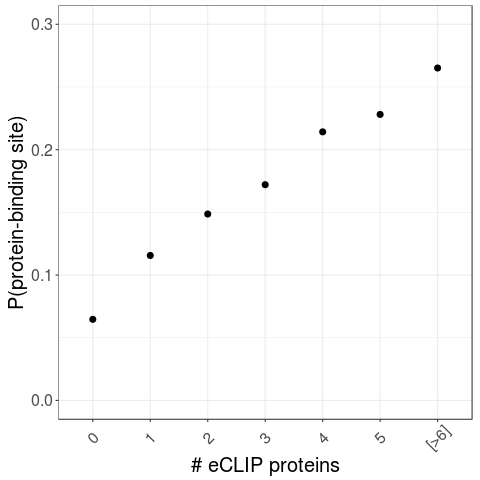

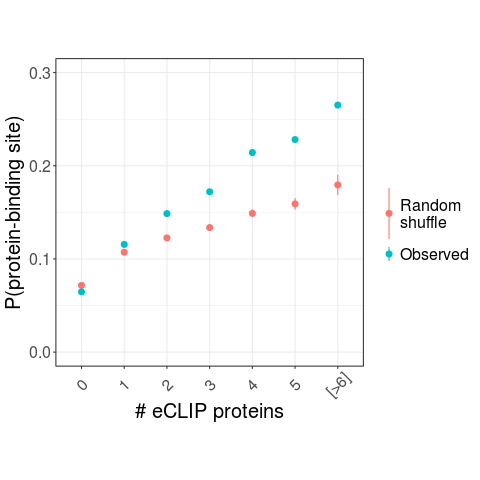

In [91]:
%%R -i top_obs_vs_random

print(head(top_obs_vs_random))

top_obs_vs_random[['eCLIP_bin']] <- mapvalues(
    top_obs_vs_random[['eCLIP_bin']] , from=6, to=c("[>6]"))

#[obs_vs_random[['eCLIP_bin']]==7] <- "[7-9]"
#obs_vs_random[['eCLIP_bin']][obs_vs_random[['eCLIP_bin']]==8] <- "[9-12]"
#obs_vs_random[['eCLIP_bin']][obs_vs_random[['eCLIP_bin']]==9] <- ">[12-15]"
#obs_vs_random[['eCLIP_bin']][obs_vs_random[['eCLIP_bin']]==10] <- ">15"

top_obs_vs_random[['eCLIP_bin']] <- factor(top_obs_vs_random[['eCLIP_bin']],
                                           levels=unique(top_obs_vs_random[['eCLIP_bin']]))

df_for_plotting <- melt(top_obs_vs_random, id.vars=c("eCLIP_bin", "iteration"))

p <- ggplot(df_for_plotting[df_for_plotting$variable == "obs",], aes(eCLIP_bin, value)) +
stat_summary(fun.data = mean_sdl, fun.args = list(mult = 1)) +
theme_bw() +
theme(aspect.ratio=1, text=element_text(size=20)) +
theme(axis.text.x=element_text(angle=45, vjust=0.5, hjust=0.5)) +
xlab("# eCLIP proteins") + ylab("P(protein-binding site)") +
ylim(0,0.3)

print(p)

p2 <- p %+% df_for_plotting + aes(colour=variable) +
scale_colour_discrete(name="", labels=c("\nRandom\nshuffle\n", "Observed"))

print(p2)
ggsave("./eCLIP_n_top_peaks_prob_oops.png")

In [72]:
head_windows_sig = windows_sig.head(10000)

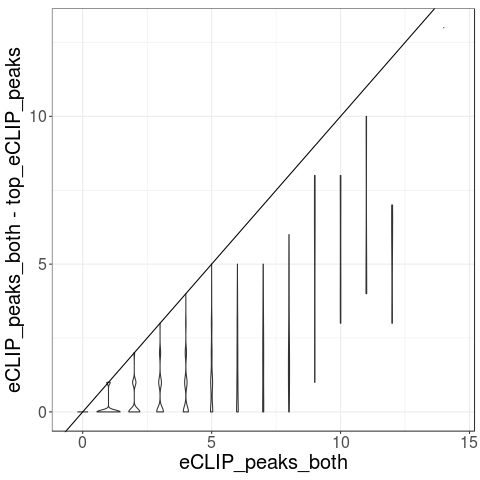

In [77]:
%%R -i head_windows_sig
p <- ggplot(head_windows_sig,
            aes(eCLIP_peaks_both, eCLIP_peaks_both-top_eCLIP_peaks, group=eCLIP_peaks_both)) +
geom_violin() + my_theme + geom_abline(slope=1)
print(p)

In [29]:
%%R
print(summary(window_model_single_proteins))


Call:
glm(formula = formula(model), family = "binomial", data = windows_sig)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8221  -0.3889  -0.2699  -0.2108   3.1268  

Coefficients:
                  Estimate Std. Error  z value Pr(>|z|)    
(Intercept)      -3.911160   0.008935 -437.734  < 2e-16 ***
log(baseMean, 2)  0.664701   0.002858  232.610  < 2e-16 ***
GRWD1            -0.163497   0.024590   -6.649 2.95e-11 ***
DDX24            -0.062018   0.026557   -2.335 0.019529 *  
YBX3             -0.143352   0.022443   -6.387 1.69e-10 ***
PRPF8            -0.270267   0.027104   -9.971  < 2e-16 ***
UPF1              0.431928   0.022364   19.314  < 2e-16 ***
UCHL5            -0.294704   0.031697   -9.298  < 2e-16 ***
PPIG             -0.081173   0.029956   -2.710 0.006734 ** 
RPS3              0.371856   0.023902   15.558  < 2e-16 ***
IGF2BP1           0.908562   0.022214   40.900  < 2e-16 ***
PCBP2             0.304253   0.024661   12.337  < 2e-16 ***
ZNF622       

In [30]:
%%R -i  protein_counts
print(protein_counts)

   GRWD1    DDX24     YBX3    PRPF8     UPF1    UCHL5     PPIG     RPS3 
   28200    23524    22091    21798    20813    20711    20465    17802 
 IGF2BP1    PCBP2   ZNF622     FXR2  IGF2BP2    SF3B4    DDX3X    EIF3H 
   17138    17108    16209    14354    13137    12950    12557    10457 
    SND1     FMR1     PUM2   EFTUD2     SUB1   METAP2   LIN28B  FAM120A 
   10438    10066     8527     6962     6916     6694     6208     6150 
   BUD13    DDX55   GEMIN5  IGF2BP3    RBM15    SF3A3    U2AF2   HNRNPK 
    5809     5686     5185     4169     4158     3957     3748     3327 
   GPKOW    NOLC1     DDX6   HNRNPL    TRA2A    PTBP1    DDX59    KHSRP 
    3074     2469     2433     2322     2168     2034     2022     1909 
    FXR1    SF3B1   CSTF2T   RBFOX2      QKI    TBRG4   SERBP1   DROSHA 
    1870     1744     1684     1682     1677     1653     1599     1583 
   FUBP3   SMNDC1    U2AF1    LARP4     NONO    AGGF1    SUGP2    RBM22 
    1445     1378     1250     1248     1235     11

In [31]:
%%R


windows_sig$reads_bin <- cut2(windows_sig$baseMean, g=12)

print(head(windows_sig))

                 Row.names baseMean log2FoldChange          padj contig
328951 ENSG00000133112_381 704.5264       2.377479 2.287427e-153  chr13
328952 ENSG00000133112_382 487.7085       2.579851 1.853189e-149  chr13
79058    ENSG00000075624_7 559.9679      -4.035280 1.643532e-139   chr7
79069    ENSG00000075624_8 436.6042      -3.772876 5.220394e-129   chr7
185521 ENSG00000108107_146 958.8406       2.219051 4.844314e-120  chr19
644003 ENSG00000183569_576 316.4985       2.774384 7.336813e-120  chr22
          start      end eCLIP_peaks_either eCLIP_peaks_both sig GRSF1 IGF2BP1
328951 45341090 45341130                  2                1   0     0       0
328952 45341110 45341150                  3                1   0     0       0
79058   5527290  5527330                  3                1   1     0       0
79069   5527310  5527350                  3                2   1     0       0
185521 55388264 55388304                  1                0   0     0       0
644003 42565136 425651

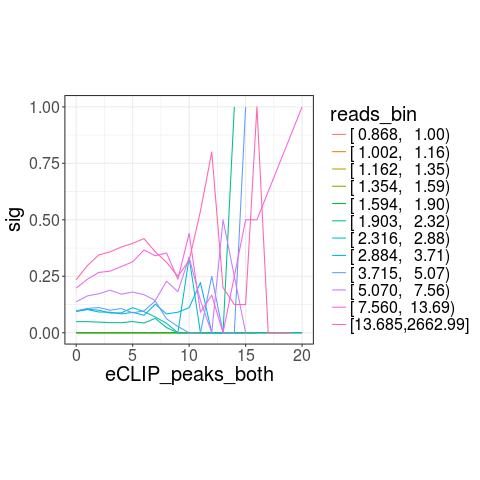

In [33]:
%%R


p <- ggplot(windows_sig, aes(eCLIP_peaks_both, sig, colour=reads_bin, group=reads_bin)) +
    stat_summary(fun.y="mean", geom="line") + xlim(0,20) + my_theme

print(p)

                 Row.names baseMean log2FoldChange          padj contig
328951 ENSG00000133112_381 704.5264       2.377479 2.287427e-153  chr13
328952 ENSG00000133112_382 487.7085       2.579851 1.853189e-149  chr13
79058    ENSG00000075624_7 559.9679      -4.035280 1.643532e-139   chr7
79069    ENSG00000075624_8 436.6042      -3.772876 5.220394e-129   chr7
185521 ENSG00000108107_146 958.8406       2.219051 4.844314e-120  chr19
644003 ENSG00000183569_576 316.4985       2.774384 7.336813e-120  chr22
          start      end eCLIP_peaks_either eCLIP_peaks_both sig GRSF1 IGF2BP1
328951 45341090 45341130                  2                1   0     0       0
328952 45341110 45341150                  3                1   0     0       0
79058   5527290  5527330                  3                1   1     0       0
79069   5527310  5527350                  3                2   1     0       0
185521 55388264 55388304                  1                0   0     0       0
644003 42565136 425651

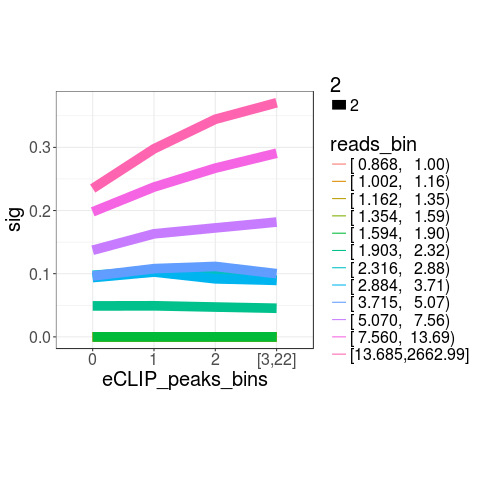

In [37]:
%%R

#print(head(windows_sig$eCLIP_peaks))

windows_sig$eCLIP_peaks_bins <- cut2(windows_sig$eCLIP_peaks_both, g=12)

print(head(windows_sig))


p <- ggplot(windows_sig, aes(eCLIP_peaks_bins, sig, size=2, colour=reads_bin, group=reads_bin)) +
    stat_summary(fun.y="mean", geom="line") + my_theme
print(p)

                 Row.names baseMean log2FoldChange          padj contig
328951 ENSG00000133112_381 704.5264       2.377479 2.287427e-153  chr13
328952 ENSG00000133112_382 487.7085       2.579851 1.853189e-149  chr13
79058    ENSG00000075624_7 559.9679      -4.035280 1.643532e-139   chr7
79069    ENSG00000075624_8 436.6042      -3.772876 5.220394e-129   chr7
185521 ENSG00000108107_146 958.8406       2.219051 4.844314e-120  chr19
644003 ENSG00000183569_576 316.4985       2.774384 7.336813e-120  chr22
          start      end eCLIP_peaks_either eCLIP_peaks_both sig GRSF1 IGF2BP1
328951 45341090 45341130                  2                1   0     0       0
328952 45341110 45341150                  3                1   0     0       0
79058   5527290  5527330                  3                1   1     0       0
79069   5527310  5527350                  3                2   1     0       0
185521 55388264 55388304                  1                0   0     0       0
644003 42565136 425651

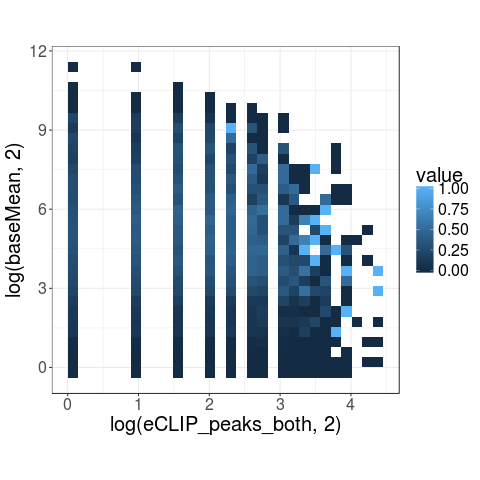

In [35]:
%%R

#print(head(windows_sig$eCLIP_peaks))

windows_sig$reads_bin2 <- as.numeric(as.character(cut2(windows_sig$baseMean, g=20, levels.mean=T)))

windows_sig$eCLIP_peaks_bins <- as.numeric(as.character(
    cut2(windows_sig$eCLIP_peaks_both, g=20, levels.mean=T)))

print(head(windows_sig))


p <- ggplot(windows_sig, aes(log(eCLIP_peaks_both,2), log(baseMean,2), z=sig)) +
    stat_summary_2d() + my_theme
print(p)

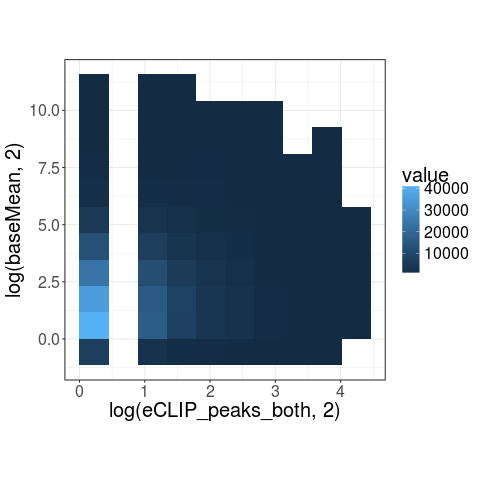

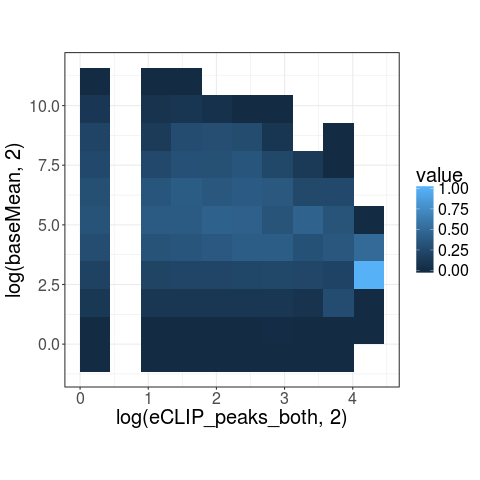

In [36]:
%%R

p <- ggplot(windows_sig, aes(log(eCLIP_peaks_both,2), log(baseMean,2), z=sig)) +
    stat_summary_2d(bins=10, fun=length) + my_theme
print(p)

p <- ggplot(windows_sig, aes(log(eCLIP_peaks_both,2), log(baseMean,2), z=sig)) +
    stat_summary_2d(bins=10) + my_theme
print(p)